# Anomaly Detection in Cryptocurrency OHLC Data

## Introduction

In the rapidly evolving world of cryptocurrencies, the ability to identify anomalies in price data is crucial for traders and investors alike. Anomalies can provide insights into market behavior, signal potential trading opportunities, or highlight areas that warrant further investigation. This notebook aims to explore and test various statistical and machine learning techniques to detect anomalies in cryptocurrency price data, specifically focusing on the OHLC (Open, High, Low, Close) and volume data, to derive, if any, useful information exist for a specific usecase.

With that said, it would be ideal to apply anomaly detection on LOB and Exceuted orders data to produce meaningful results.

The primary objective of this notebook is to demonstrate the application of several popular anomaly detection algorithms, compare their performance, and provide visualizations to aid understanding. The notebook is structured as a research material, with detailed explanations of the algorithms, their implementation, and the interpretation of results.


## Data Collection and Preprocessing

In [1]:
import sys
sys.path.append('/Volumes/Work&Study/Trading/Data_work')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures

from myconfig import api_key, secret
from binance.client import Client

api_key = api_key
api_secret = secret
client = Client(api_key, api_secret)

symbols = ['BTCUSDT']
ohlcv_df = pd.DataFrame()

def get_symbol_data(symbol):
    klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1HOUR, "01 Apr, 2022", "07 May, 2023")
    symbol_df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    symbol_df['timestamp'] = pd.to_datetime(symbol_df['timestamp'], unit='ms')

    return symbol_df

with concurrent.futures.ThreadPoolExecutor() as executor:
    symbol_dfs = list(executor.map(get_symbol_data, symbols))
    
ohlcv_df = pd.concat(symbol_dfs, axis=1)
ohlcv_df.sort_index(inplace=True)
ohlcv_df.drop_duplicates(inplace=True)
ohlcv_df = ohlcv_df.loc[:,~ohlcv_df.columns.duplicated()]

In [2]:
def plot_anomaly(df, column_name, close_column='close'):
    plt.figure(figsize=(18, 6))
    plt.plot(df.index, df[close_column], label='Close Price', alpha=0.8)
    plt.scatter(df[df[column_name] == 1].index, df[df[column_name] == 1][close_column], c='blue', label=column_name, marker='o')
    plt.xlabel('Index')
    plt.ylabel('Close Price')
    plt.title('Close Price with Anomalies')
    plt.legend()
    plt.show()

df_ = ohlcv_df.copy() #creating extra copies
df_ = df_.apply(pd.to_numeric, errors='coerce')

df_['returns'] = df_['close'].pct_change()
df_ = df_.dropna(axis=0)
df = df_.copy()

df = df.set_index('timestamp')
df = df.apply(pd.to_numeric, errors='coerce')
df_ = df.copy()

columns_of_interest = ['open', 'high', 'low', 'close', 'volume', 'returns']
df

#save the dataframe to csv
df.to_csv('btcusdt.csv')

# Anomaly Detection Techniques
>

Anomaly detection is the process of identifying data points that deviate significantly from the expected behavior or patterns in the dataset. These data points, known as anomalies or outliers, can often provide valuable insights into the underlying processes generating the data. In the context of cryptocurrency price data, anomalies can represent sudden price spikes or drops, unexpected changes in trading volume, or other unusual market activities. Detecting such anomalies is essential for traders and investors, as it can help them identify potential trading opportunities, assess market risks, or uncover fraudulent activities.

**An overview of the algorithms I will be covering and testing in this notebook:**

- **Exponential Moving Average (EMA) based methods:** This approach calculates the EMA of returns or volatility and flags significant deviations from the EMA as potential anomalies. It can be efficiently implemented using NumPy.

- **Interquartile Range (IQR) Method:** The IQR method calculates the range between the first and third quartiles of the data distribution. Data points that fall outside of a predefined multiple of the IQR can be considered as potential anomalies. This method is suitable for analyzing high-frequency data and can be implemented efficiently using NumPy.

- **Mahalanobis Distance:** This method measures the distance of a data point from the mean of a multivariate data set, considering the data's covariance structure. Points with high Mahalanobis distances can be considered as potential anomalies. It can be implemented using NumPy's linear algebra functions and is suitable for detecting multivariate anomalies in high-frequency data.

- **Local Outlier Factor (LOF):** LOF is a density-based method that measures the local deviation of a data point with respect to its neighbors. Points with high LOF values are considered as potential anomalies. Although LOF is computationally more complex than other methods, it can be implemented using NumPy for small to moderately-sized data sets.

- **Isolation Forest:** This unsupervised learning algorithm builds an ensemble of random decision trees to isolate anomalies in the data. Points that can be isolated quickly are considered as potential anomalies.

- **Earth Mover's Distance (EMD):** Measurea the discrepancy between two data distributions and can be implemented using NumPy

- **Kolmogorov-Smirnov (KS) Distance:** Similar to ED, Both of these methods measure the discrepancy between two data distributions and can be implemented using NumPy. However, they might be more computationally intensive compared to other options.

- **ICSS Test:** The ICSS test is designed to detect changes in variance and can be implemented using NumPy. This method is specifically relevant for high-frequency trading.

- **Bayesian Structural Time Series (BSTS):** By fitting a BSTS model to the data and analyzing the residuals, you can identify unexpected fluctuations. BSTS models can incorporate various components, such as local trends, seasonal patterns, and external regressors.

- **Grubbs' Test:** Grubbs' test is a statistical method to detect outliers in a univariate data set. It can be applied to the OHLC data or derived features, such as returns or volatility, to identify extreme values that might indicate anomalies.

- **One-Class Support Vector Machine (OCSVM):** OCSVM is an unsupervised learning algorithm that constructs a hyperplane to separate normal data points from potential anomalies. Points that fall outside the hyperplane are considered as potential anomalies.

By implementing and comparing these methods on the cryptocurrency price data, we aim to gain a deeper understanding of their behavior and performance in this specific domain.


## Exponential Moving Average (EMA) Based Method

The Exponential Moving Average (EMA) is a popular technique used in time series analysis to smooth out data and capture underlying trends. Unlike the Simple Moving Average (SMA), which assigns equal weights to all data points in the window, EMA assigns exponentially decreasing weights to older data points. This allows EMA to respond more quickly to recent changes in the data. In the context of anomaly detection, we can use the EMA to identify data points that significantly deviate from the expected pattern, which might be considered as potential anomalies.

Mathematical Formulation
The EMA at time $t$ is calculated as follows:
$$
EMA_t = \alpha \cdot x_t + (1 - \alpha) \cdot EMA_{t-1},
$$

where $x_t$ is the data point at time $t$, $EMA_{t-1}$ is the EMA at time $t-1$, and $\alpha$ is the smoothing factor, which determines the relative importance of the current data point compared to previous ones. The smoothing factor $\alpha$ ranges between 0 and 1. A larger $\alpha$ gives more weight to recent data points, making the EMA more responsive to recent changes.

To detect potential anomalies, we compute the absolute difference between the data points and their corresponding EMAs:

$$
d_t = |x_t - EMA_t|.
$$

If the absolute difference $d_t$ exceeds a predefined threshold, we flag the data point as a potential anomaly.


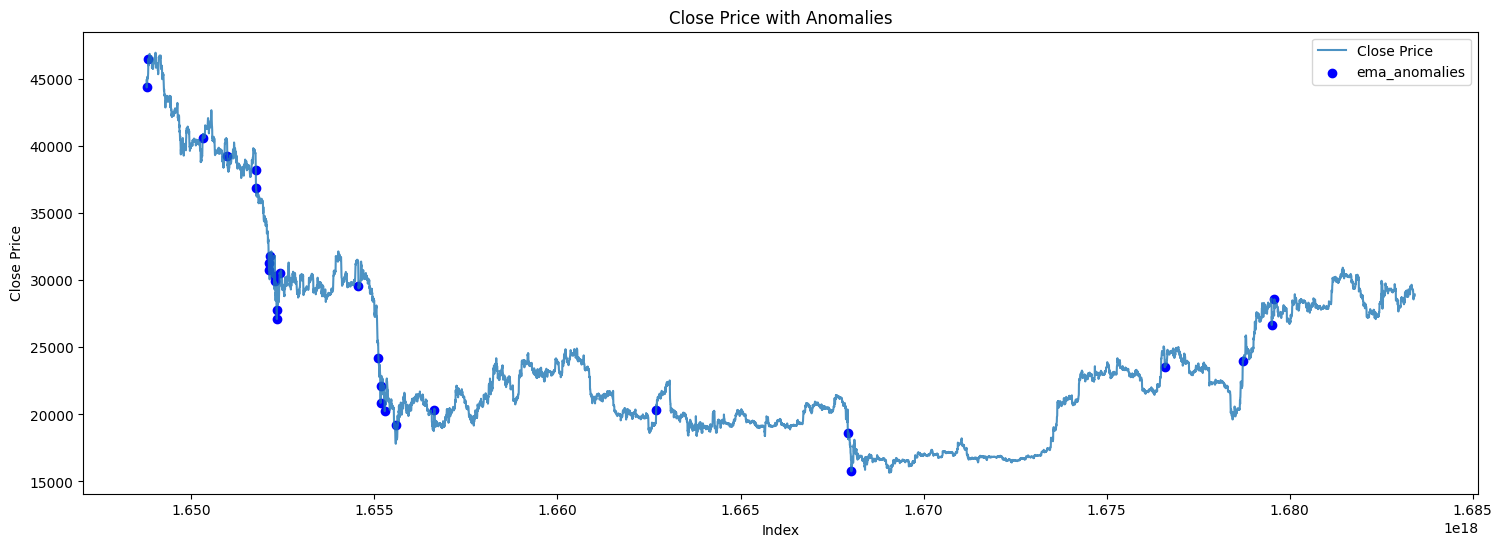

In [3]:
def ema_anomalies(data, alpha, threshold):
    ema = np.zeros_like(data)
    ema[0] = data[0]
    anomalies = []

    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]
        if np.abs(data[i] - ema[i]) > threshold:
            anomalies.append(i)

    return anomalies


threshold = 50
alpha = 0.89

for column in columns_of_interest:
    data = df[column].values.astype(float)
    indices = ema_anomalies(data, alpha, threshold)
    df[f'{column}_ema_anomalies'] = 0
    df.iloc[indices, df.columns.get_loc(f'{column}_ema_anomalies')] = 1

df['ema_anomalies'] = np.where((df['open_ema_anomalies'] == 1) & 
                               (df['high_ema_anomalies'] == 1) & 
                               (df['low_ema_anomalies'] == 1) & 
                               (df['close_ema_anomalies'] == 1) & 
                               (df['volume_ema_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'ema_anomalies')

A Generalized Exponential Moving Average (GEMA) model with Particle Filtering and Anomaly Detection can be an advanced technique that can provide more accurate anomaly detection compared to the simple EMA method. In this approach, we combine the GEMA model with a Particle Filter (PF) to track the time-varying parameters of the GEMA model, and we use statistical hypothesis tests to detect anomalies in the data.


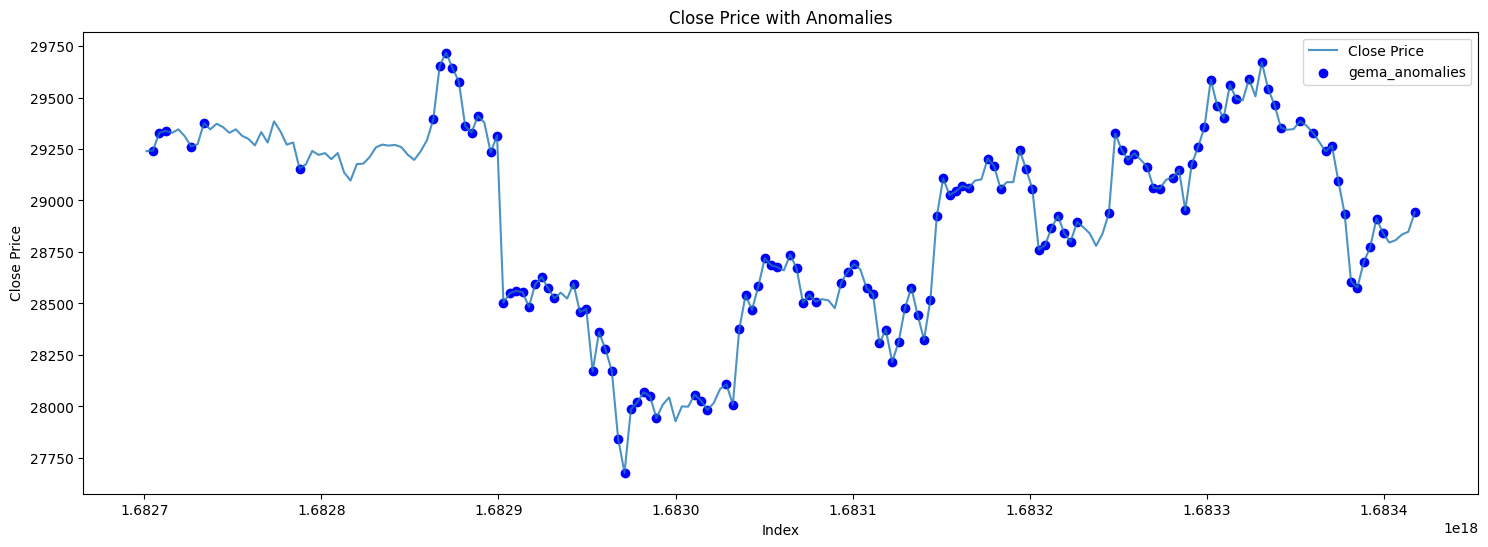

In [4]:
from filterpy.monte_carlo import systematic_resample
from statsmodels.tsa.stattools import adfuller

def gema_anomalies(data, n_particles, n_resampling, threshold):
    particles = np.random.randn(n_particles, len(data))
    weights = np.ones(n_particles) / n_particles

    anomalies = []
    
    for t in range(1, len(data)):
        # Particle Filter prediction step
        particles[:, t] = particles[:, t - 1] + np.random.randn(n_particles)

        # Compute the weights based on the likelihood of the observed data
        likelihood = np.exp(-0.5 * ((data[t] - particles[:, t]) ** 2))
        weights *= likelihood
        weights += 1.e-300  # Avoid round-off errors
        weights /= np.sum(weights)

        # Resample the particles if the effective number of particles is too low
        if 1 / np.sum(weights ** 2) < n_resampling:
            indexes = systematic_resample(weights)
            particles = particles[indexes]
            weights = np.ones(n_particles) / n_particles

        # Anomaly Detection using the Augmented Dickey-Fuller test
        adf_test = adfuller(particles[:, t], autolag='AIC')
        if adf_test[0] < adf_test[4]['1%'] and np.abs(data[t] - np.mean(particles[:, t])) > threshold:
            anomalies.append(t)

    return anomalies

df = df_.copy()
df = df.tail(200)

n_particles = 1000
n_resampling = 80
threshold = 1200

for column in columns_of_interest:
    data = df[column].values.astype(float)
    indices = gema_anomalies(data, n_particles, n_resampling, threshold)
    df[f'{column}_gema_anomalies'] = 0
    df.iloc[indices, df.columns.get_loc(f'{column}_gema_anomalies')] = 1

df['gema_anomalies'] = np.where((df['open_gema_anomalies'] == 1) & 
                                (df['high_gema_anomalies'] == 1) & 
                                (df['low_gema_anomalies'] == 1) & 
                                (df['close_gema_anomalies'] == 1) & 
                                (df['volume_gema_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'gema_anomalies')

## Interquartile Range (IQR) Method

The Interquartile Range (IQR) method is a robust and straightforward technique for identifying potential anomalies in a dataset. It is based on the concept of the IQR, which is the range between the first quartile (25th percentile) and the third quartile (75th percentile) of the data distribution. The IQR provides a measure of the spread of the data and is less sensitive to outliers than the standard deviation or variance.

The IQR method for anomaly detection works as follows:

- Calculate the first quartile (Q1) and the third quartile (Q3) of the data.
- Compute the IQR as the difference between Q3 and Q1.
- Define a threshold, typically a multiple of the IQR (for example, 1.5 times the IQR).
- Identify data points that fall below Q1 minus the threshold or above Q3 plus the threshold as potential anomalies.



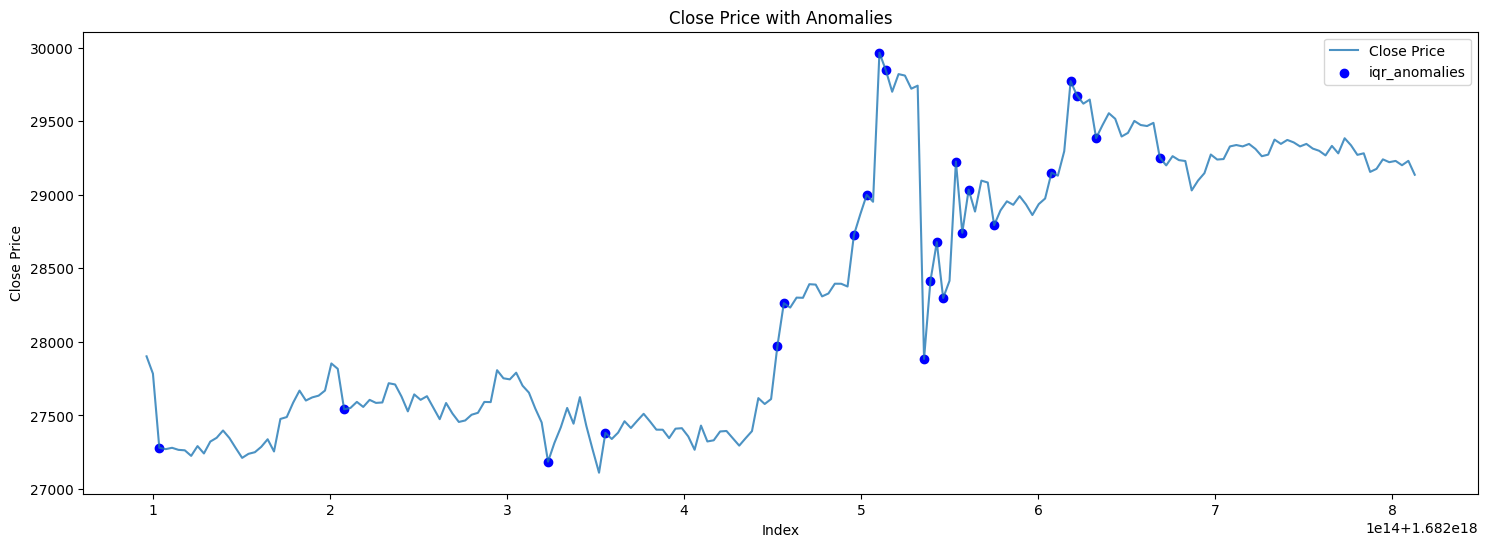

In [93]:
def iqr_anomalies(data, k=1.5): #k = 1.5 is the meaningfull value
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    anomalies = np.where((data < lower_bound) | (data > upper_bound))[0]
    return anomalies


for column in columns_of_interest:
    data = df[column].values.astype(float)
    indices = iqr_anomalies(data, k=1.5) #1.5 is meaningful, but iqr may not be suited for financial timeseries
    df[f'{column}_iqr_anomalies'] = 0
    df.iloc[indices, df.columns.get_loc(f'{column}_iqr_anomalies')] = 1

df['iqr_anomalies'] = np.where(#(df['open_iqr_anomalies'] == 1) | 
                                #(df['high_iqr_anomalies'] == 1) | 
                                #(df['low_iqr_anomalies'] == 1) | 
                                #(df['close_iqr_anomalies'] == 1) | 
                                (df['returns_iqr_anomalies'] == 1) |
                                (df['volume_iqr_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'iqr_anomalies')

##  Mahalanobis Distance

The Mahalanobis Distance is a statistical measure that computes the distance between a data point and the mean of the dataset while accounting for the correlations between variables. It is particularly useful in multivariate data analysis and can be an effective method for detecting anomalies.

The Mahalanobis distance for a multivariate data point x is given by the following formula:

$$D_M(x) = (x - \mu)^T \Sigma^{-1} (x - \mu)$$

where:

- $x$ is the data point (a row vector)
- $\mu$ is the mean vector of the dataset (a row vector)
- $\Sigma$ is the covariance matrix of the dataset
- $\Sigma^{-1}$ is the inverse of the covariance matrix
- $D_M(x)$ is the Mahalanobis distance of the data point x
- In the context of anomaly detection, data points with Mahalanobis distances larger than a given threshold are considered anomalies.


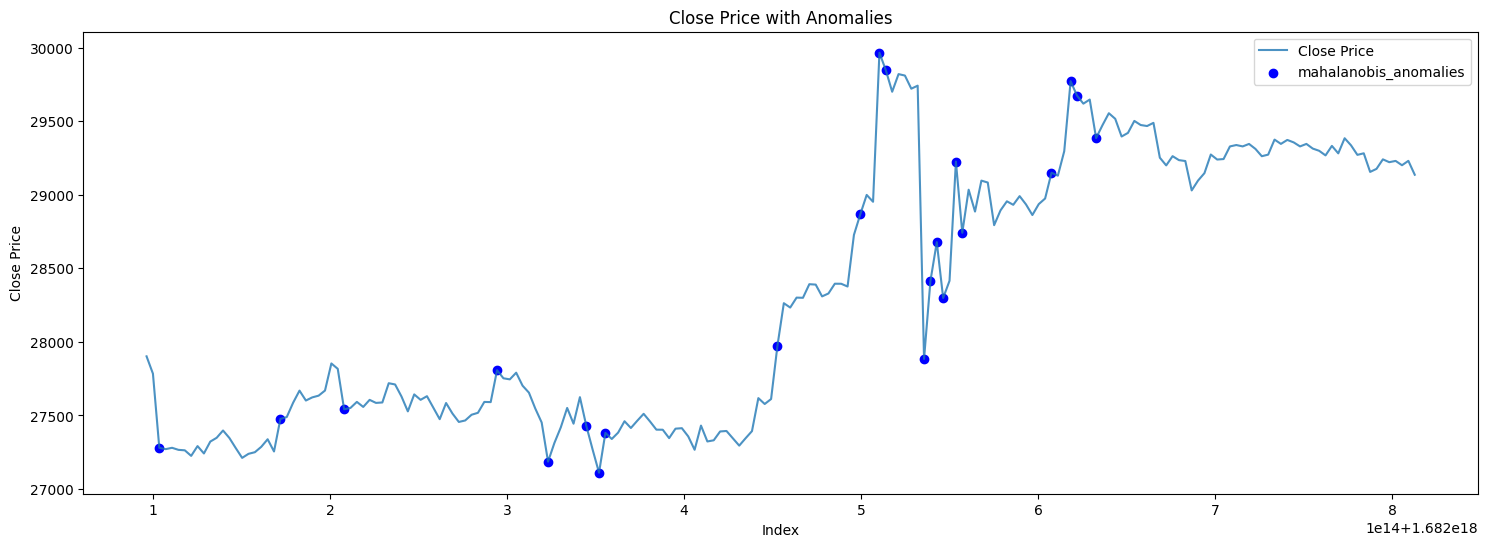

In [100]:
def mahalanobis_anomalies(data, threshold):
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_cov = np.linalg.pinv(cov)
    centered_data = data - mean
    distances = np.sqrt(np.sum(centered_data @ inv_cov * centered_data, axis=1))
    anomalies = np.where(distances > threshold)[0]
    return anomalies

df_interest = df[columns_of_interest]
data = df_interest.values.astype(float)
indices = mahalanobis_anomalies(data, threshold=2.8)

df['mahalanobis_anomalies'] = 0
df.iloc[indices, df.columns.get_loc('mahalanobis_anomalies')] = 1

plot_anomaly(df, 'mahalanobis_anomalies')

## Local Outlier Factor (LOF) 

The Local Outlier Factor (LOF) is a density-based anomaly detection technique that computes the local deviation of a data point relative to its neighbors. It is capable of identifying anomalies in datasets where the density of the data points is not uniform, making it a powerful technique for detecting outliers in complex data distributions.

The main idea behind LOF is to compare the local density of a data point with the local densities of its neighbors. If a data point's local density is significantly lower than that of its neighbors, it is considered an outlier.

**Key steps in the LOF algorithm:**

- Compute the k-nearest neighbors of each data point.
- Calculate the local reachability density (LRD) of each data point.
- Calculate the LOF score for each data point.

Parameter notations:

- Let $x_i$ and $x_j$ be two data points in the dataset.
- Let $k$ be the number of nearest neighbors considered in the algorithm.
- Let $d(x_i, x_j)$ denote the Euclidean distance between data points $x_i$ and $x_j$.
- Let $k\text{-}dist(x_i)$ be the distance from $x_i$ to its $k$-th nearest neighbor.
- Let $N_k(x_i)$ be the set of $k$ nearest neighbors of $x_i$, not including $x_i$ itself.

1. Compute the k-nearest neighbors of each data point:

    To compute the $k$ nearest neighbors of each data point, we can use a k-d tree, a ball tree, or any other nearest-neighbor search algorithm. For simplicity, we will not cover the details of these algorithms here.

2. Calculate the local reachability density (LRD) of each data point:
    The reachability distance of $x_i$ with respect to $x_j$ is defined as:

$$reach-dist_k(x_i, x_j) = max\{k-dist(x_j), d(x_i, x_j)\}$$

    
The local reachability density of a data point $x_i$ is defined as the inverse of the average reachability distance of $x_i$ from its $k$ neighbors:

$$LRD_k(x_i) = \frac{1}{\frac{1}{k} \sum_{x_j \in N_k(x_i)} reach-dist_k(x_i, x_j)}$$

3. Calculate the LOF score for each data point:

    The LOF score of a data point $x_i$ is the average ratio of the LRDs of its neighbors to its own LRD:

$$ LOF_k(x_i) = \frac{1}{k} \sum_{x_j \in N_k(x_i)} \frac{LRD_k(x_j)}{LRD_k(x_i)} $$



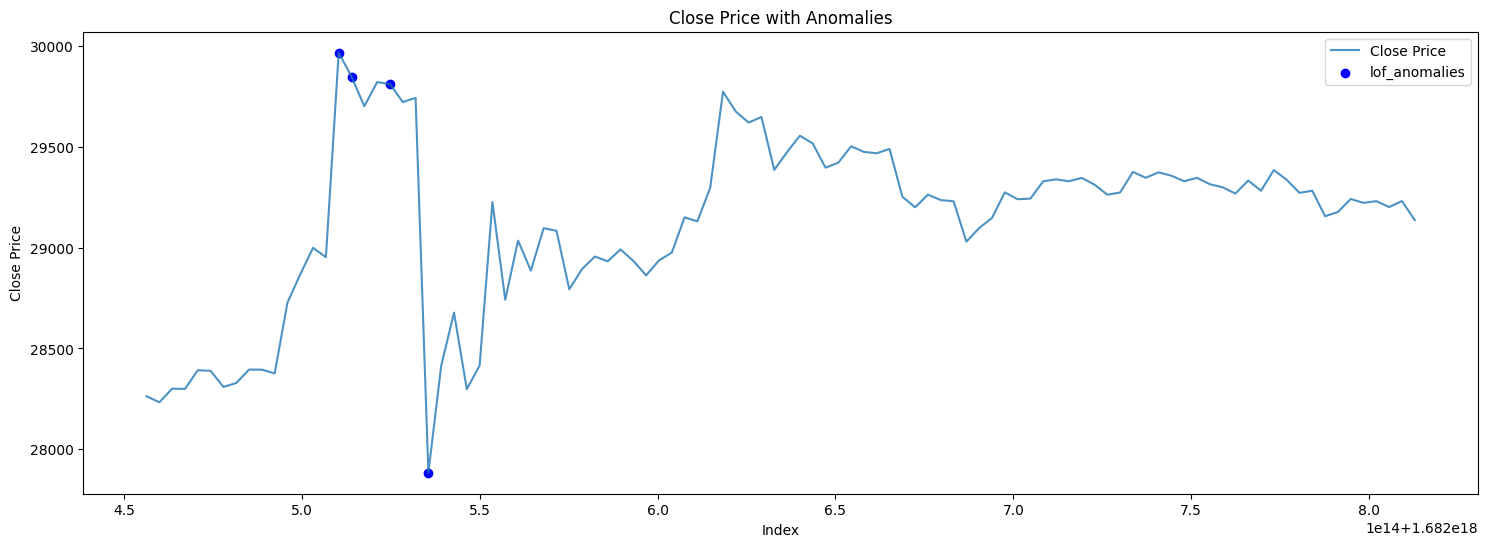

In [103]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def k_distance(x, data, k):
    distances = np.array([euclidean_distance(x, y) for y in data])
    sorted_indices = np.argsort(distances)
    kth_distance = distances[sorted_indices[k-1]]
    neighbors = sorted_indices[:k]
    return kth_distance, neighbors

def local_reachability_density(x, data, k):
    k_distance_x, neighbors_x = k_distance(x, data, k)
    reachability_distances = [max(k_distance(data[i], data, k)[0], euclidean_distance(x, data[i])) for i in neighbors_x]
    lrd = k / np.sum(reachability_distances)
    return lrd, neighbors_x

def local_outlier_factor(x, data, k):
    lrd_x, neighbors_x = local_reachability_density(x, data, k)
    lrd_ratios = [local_reachability_density(data[i], data, k)[0] for i in neighbors_x]
    lof = np.sum(lrd_ratios) / (len(neighbors_x) * lrd_x)
    return lof

def lof_anomalies(data, n_neighbors, contamination):
    lof_scores = np.array([local_outlier_factor(data[i], data, n_neighbors) for i in range(len(data))])
    threshold = np.percentile(lof_scores, (1 - contamination) * 100)
    anomalies = np.where(lof_scores > threshold)[0]
    return anomalies

df = df_.copy()
df = df.tail(100)

n_neighbors = 20  
contamination = 0.01  

for column in columns_of_interest:
    data = df[column].values.astype(float).reshape(-1, 1)
    indices = lof_anomalies(data, n_neighbors, contamination)
    df[f'{column}_lof_anomalies'] = 0
    df.iloc[indices, df.columns.get_loc(f'{column}_lof_anomalies')] = 1

df['lof_anomalies'] = np.where((df['open_lof_anomalies'] == 1) |
                                (df['high_lof_anomalies'] == 1) |
                                (df['low_lof_anomalies'] == 1) |
                                (df['close_lof_anomalies'] == 1) |
                                (df['returns_lof_anomalies'] == 1) |
                                (df['volume_lof_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'lof_anomalies')

## Isolation Forest:

Isolation Forest is an unsupervised learning algorithm for anomaly detection that works by isolating observations in a random decision tree structure. This method is particularly useful for detecting outliers in high-dimensional datasets.

The main idea behind the Isolation Forest algorithm is that anomalies are easier to isolate than normal data points. The algorithm builds multiple random decision trees (called an "ensemble") to recursively partition the dataset. The number of partitions needed to isolate an anomaly is usually smaller than the number of partitions needed for normal data points. By calculating the average number of partitions needed to isolate each data point in the ensemble, the algorithm can identify potential anomalies based on their relative isolation scores.

**A high-level overview of the Isolation Forest algorithm:**

- Build an ensemble of random decision trees.
- For each data point, compute the average number of partitions (or depth) required to isolate it across all trees in the ensemble.
- Calculate the anomaly score based on the average depth.
- Determine a threshold for the anomaly score to classify points as anomalies.

**Building Random Decision Trees**

The Isolation Forest algorithm constructs random decision trees by recursively partitioning the dataset along randomly chosen features and split values. Each tree is grown until all data points are isolated or a maximum depth is reached.

**Path Length**

The path length for a data point is the number of edges (or partitions) traversed from the root node to the leaf node containing the point. The average path length in the ensemble is used as an anomaly score. Intuitively, a shorter path length corresponds to a higher likelihood of being an anomaly.

The expected path length $E(h(x))$ for a data point $x$ is given by:

$$E(h(x)) = c(n) + \frac{2H(n - 1) - (2(n - 1)/n)}{n}$$

where $n$ is the number of data points, $H(i)$ is the harmonic number, and $c(n)$ is the average path length of an unsuccessful search in a Binary Search Tree.

**Anomaly Score**

The anomaly score $s(x)$ for a data point $x$ is calculated as:

$$s(x) = 2^{-\frac{E(h(x))}{c(n)}}$$

A higher anomaly score indicates a higher likelihood of being an anomaly.

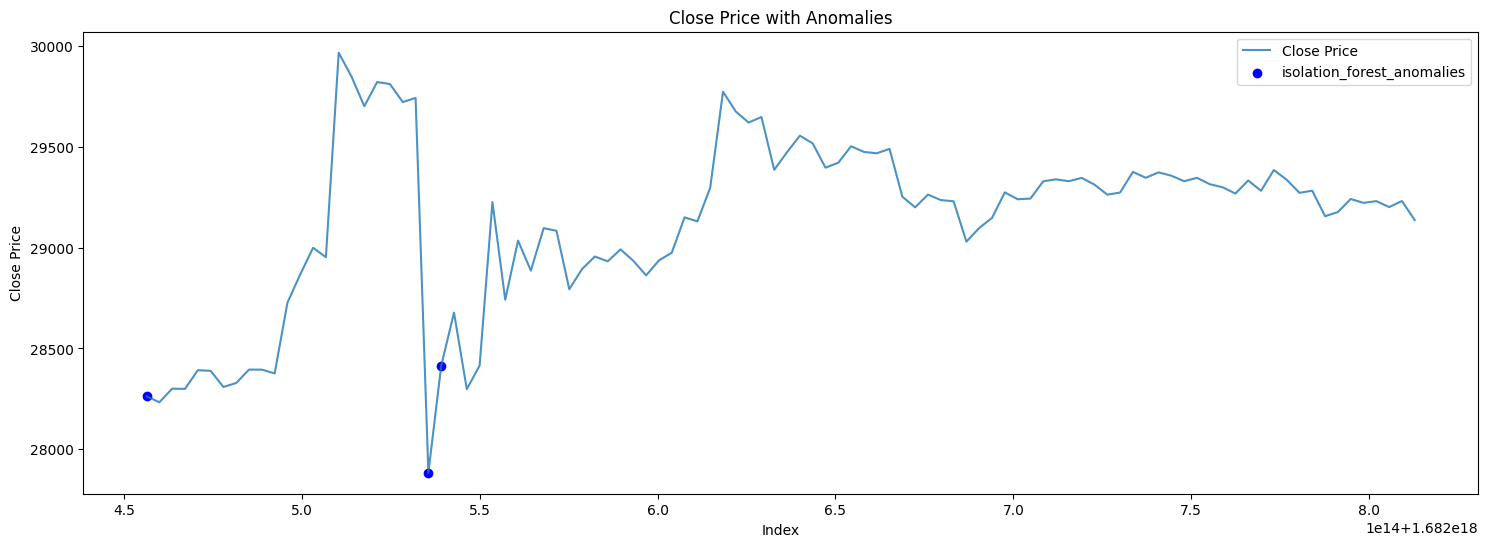

In [112]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model to your data
for column in columns_of_interest:
    data_column = df[column].values.astype(float).reshape(-1, 1)
    model.fit(data_column)

    # Predict anomalies
    predictions = model.predict(data_column)
    df[f'{column}_isolation_forest_anomalies'] = np.where(predictions == -1, 1, 0)

# Aggregate the results
df['isolation_forest_anomalies'] = np.where((df['open_isolation_forest_anomalies'] == 1) |
                                            (df['high_isolation_forest_anomalies'] == 1) |
                                            (df['low_isolation_forest_anomalies'] == 1) |
                                            (df['close_isolation_forest_anomalies'] == 1) |
                                            (df['returns_isolation_forest_anomalies'] == 1) |
                                            (df['volume_isolation_forest_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'isolation_forest_anomalies')


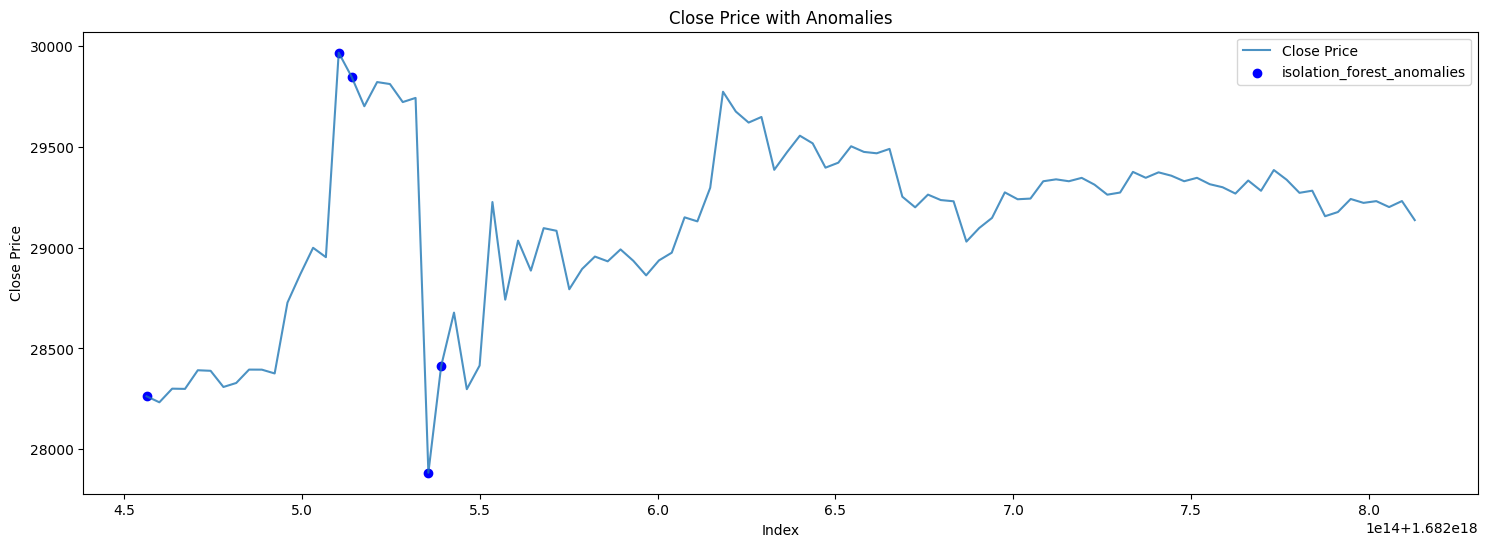

In [115]:
class TreeNode:
    def __init__(self, left=None, right=None, split_feature=None, split_value=None, depth=0, size=0):
        self.left = left
        self.right = right
        self.split_feature = split_feature
        self.split_value = split_value
        self.depth = depth
        self.size = size

def c(n):
    if n == 1:
        return 0
    return 2 * (np.log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)

def build_tree(data, max_depth, current_depth=0):
    if current_depth == max_depth or len(data) <= 1:
        return TreeNode(depth=current_depth, size=len(data))

    split_feature = np.random.randint(data.shape[1])
    split_value = np.random.uniform(data[:, split_feature].min(), data[:, split_feature].max())
    left_mask = data[:, split_feature] < split_value
    right_mask = ~left_mask

    left_child = build_tree(data[left_mask], max_depth, current_depth + 1)
    right_child = build_tree(data[right_mask], max_depth, current_depth + 1)

    return TreeNode(left=left_child, right=right_child, split_feature=split_feature, split_value=split_value)

def path_length(x, tree, current_depth=0):
    if tree.left is None and tree.right is None:
        return current_depth + c(tree.size)

    if x[tree.split_feature] < tree.split_value:
        return path_length(x, tree.left, current_depth + 1)
    else:
        return path_length(x, tree.right, current_depth + 1)

def isolation_forest(data, num_trees, max_depth):
    forest = [build_tree(data, max_depth) for _ in range(num_trees)]
    return forest

def anomaly_scores(data, forest):
    path_lengths = np.array([[path_length(x, tree) for tree in forest] for x in data])
    average_path_lengths = np.mean(path_lengths, axis=1)
    scores = 2 ** (-average_path_lengths / c(data.shape[0]))
    return scores

def isolation_forest_anomalies(data, num_trees, max_depth, contamination):
    forest = isolation_forest(data, num_trees=num_trees, max_depth=max_depth)
    scores = anomaly_scores(data, forest)

    threshold = np.percentile(scores, 100 * (1 - contamination))
    anomalies = np.where(scores >= threshold)[0]
    return anomalies


for column in columns_of_interest:
    data = df[column].values.astype(float).reshape(-1, 1)
    indices = isolation_forest_anomalies(data, num_trees=100, max_depth=int(np.ceil(np.log2(data.shape[0]))), contamination=0.02) # 2% contamination, but 0.1 is default
    df[f'{column}_isolation_forest_anomalies'] = 0
    df.iloc[indices, df.columns.get_loc(f'{column}_isolation_forest_anomalies')] = 1

df['isolation_forest_anomalies'] = np.where((df['open_isolation_forest_anomalies'] == 1) |
                                            (df['high_isolation_forest_anomalies'] == 1) |
                                            (df['low_isolation_forest_anomalies'] == 1) |
                                            (df['close_isolation_forest_anomalies'] == 1) |
                                            (df['returns_isolation_forest_anomalies'] == 1) |
                                            (df['volume_isolation_forest_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'isolation_forest_anomalies')

## Earth Mover's Distance (EMD)

Earth Mover's Distance (EMD), also known as Wasserstein distance or first-order optimal transport distance, is a measure of dissimilarity between two probability distributions over a region. EMD is particularly useful when comparing distributions with different support or when considering distributions on a continuous space. It is widely used in various domains, including computer vision, natural language processing, and statistics.

The main idea behind EMD is to model the problem of comparing two probability distributions as a transportation problem. Imagine two piles of "earth" representing the two distributions, where the height of each pile at a given location corresponds to the density of the distribution at that location. The EMD is the minimum "work" required to transform one pile into the other, where "work" is defined as the amount of earth moved multiplied by the distance it is moved.

The EMD can be more formally defined as follows. Let $P = {(x_1, w_1), (x_2, w_2), \dots, (x_m, w_m)}$ and $Q = {(y_1, v_1), (y_2, v_2), \dots, (y_n, v_n)}$ be two discrete distributions, where $x_i$ and $y_j$ represent the locations of the points and $w_i$ and $v_j$ represent the corresponding weights. The Earth Mover's Distance between $P$ and $Q$ is defined as:

$$
\text{EMD}(P,Q)= \frac{\sum_{i=1}^{m} \sum_{j=1}^{n} T_{ij} d(x_{i}, y_{j})}{\sum_{i=1}^{m} \sum_{j=1}^{n} T_{ij}}
$$


where $T_{ij}$ is the optimal transport plan between $P$ and $Q$, $d(x_i, y_j)$ is the ground distance between $x_i$ and $y_j$, and the optimal transport plan is the one that minimizes the total work.

The problem of finding the optimal transport plan can be formulated as a linear programming problem:

\begin{align*}
  & \text{minimize} & & \sum_{i=1}^{m} \sum_{j=1}^{n} T_{ij} d(x_{i}, y_{j}) \\
  & \text{subject to} & & \sum_{j=1}^{n} T_{ij} = w_{i}, \forall i \in \{1, \dots, m\} \\
  & & & \sum_{i=1}^{m} T_{ij} = v_{j}, \forall j \in \{1, \dots, n\} \\
  & & & T_{ij} \geq 0, \forall i \in \{1, \dots, m\}, \forall j \in \{1, \dots, n\}
\end{align*}
 
Here, the objective function represents the total work, and the constraints ensure that the mass is preserved during transportation.

In practice, there are several algorithms available to compute the Earth Mover's Distance, including the Hungarian algorithm, the transportation simplex method, and more efficient algorithms based on network flow theory.

**Example: Comparing two 1D distributions**

Let's consider an example of comparing two 1D distributions using the Earth Mover's Distance. The distributions are represented as two sets of weighted points:

$$
P=\{(1,0.3),(3,0.4),(5,0.3)\}
$$

The ground distance can be defined as the absolute difference between the locations, i.e., $d(x_i, y_j) = |x_i - y_j|$. To compute the EMD between $P$ and $Q$, we need to find the optimal transport plan $T_{ij}$.
One possible way to compute the optimal transport plan is to use the transportation simplex method, which is a variation of the simplex algorithm for linear programming specifically designed for transportation problems. Alternatively, you could use more advanced algorithms based on network flow theory for better computational efficiency.
After computing the optimal transport plan, the EMD can be calculated as follows:

$$\text{EMD}(P, Q) = \frac{\sum_{i=1}^{3} \sum_{j=1}^{3} T_{ij} |x_i - y_j|}{\sum_{i=1}^{3} \sum_{j=1}^{3} T_{ij}}$$

It is important to note that the EMD is not limited to 1D distributions and can be applied to higher-dimensional distributions as well. The ground distance function, $d(x_i, y_j)$, can be replaced with an appropriate distance metric depending on the underlying space, such as the Euclidean distance for continuous spaces or the Hamming distance for binary spaces.
In summary, the Earth Mover's Distance is a powerful and flexible measure of dissimilarity between two probability distributions. It is particularly useful when comparing distributions with different supports or when considering distributions on a continuous space. By formulating the problem as a transportation problem and solving it using linear programming or network flow algorithms, the EMD can be computed efficiently and used in various applications, such as anomaly detection, image retrieval, and natural language processing.



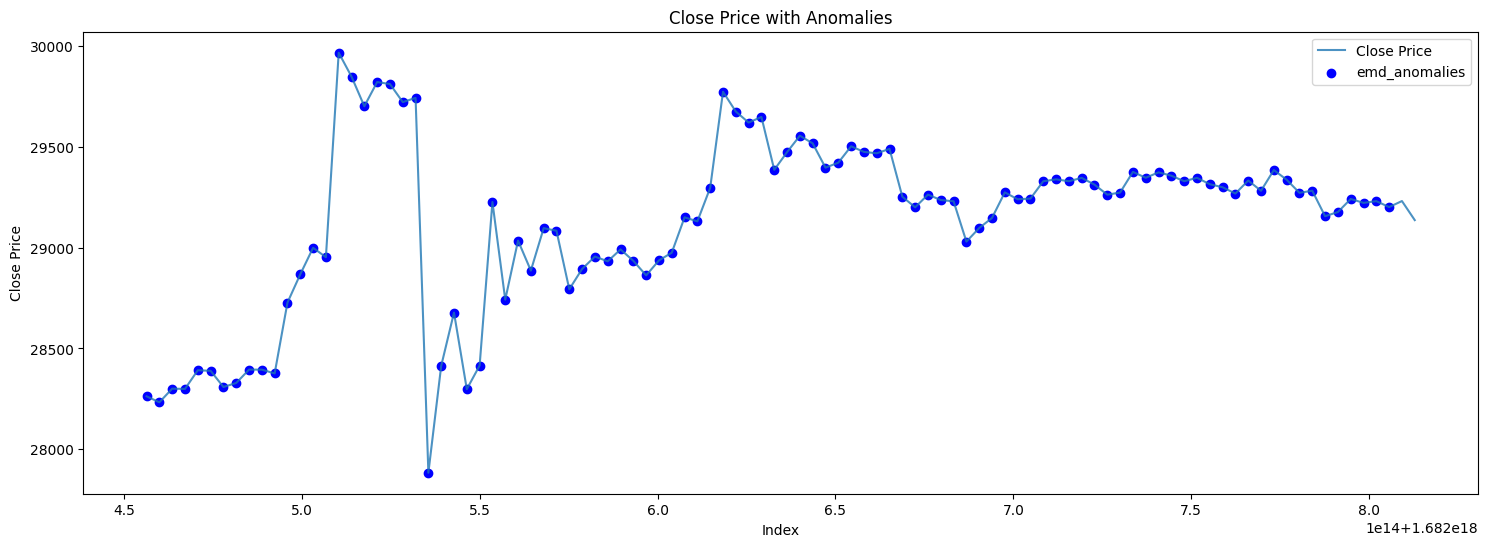

In [129]:
from scipy.stats import wasserstein_distance

def calculate_emd(window_data, overall_data, num_bins=10):
    window_hist, _ = np.histogram(window_data, bins=num_bins)
    overall_hist, _ = np.histogram(overall_data, bins=num_bins)

    window_hist = window_hist / np.sum(window_hist)
    overall_hist = overall_hist / np.sum(overall_hist)

    return wasserstein_distance(window_hist, overall_hist)

def calculate_emd_numpy(window_data, overall_data, num_bins=10):
    window_hist, _ = np.histogram(window_data, bins=num_bins)
    overall_hist, _ = np.histogram(overall_data, bins=num_bins)

    window_hist = window_hist / np.sum(window_hist)
    overall_hist = overall_hist / np.sum(overall_hist)

    cdf_window = np.cumsum(window_hist)
    cdf_overall = np.cumsum(overall_hist)

    emd = np.sum(np.abs(cdf_window - cdf_overall))

    return emd

def emd_anomalies(data, window_size, threshold, num_bins=10):
    emd_values = []
    for i in range(len(data) - window_size + 1):
        window_data = data[i:i + window_size]
        emd_value = calculate_emd_numpy(window_data, data, num_bins=num_bins) #use any
        emd_values.append(emd_value)

    emd_values = np.array(emd_values)
    anomalies = np.where(emd_values > threshold)[0]

    return anomalies, emd_values

window_size = 3
threshold = 0.1

columns_of_interest = ['open', 'high', 'low', 'close', 'returns', 'volume']
for column in columns_of_interest:
    data = df[column].values.astype(float)
    anomalies, _ = emd_anomalies(data, window_size, threshold)
    df[f'{column}_emd_anomalies'] = 0
    df.iloc[anomalies, df.columns.get_loc(f'{column}_emd_anomalies')] = 1

df['emd_anomalies'] = np.where((df['open_emd_anomalies'] == 1) |
                                (df['high_emd_anomalies'] == 1) |
                                (df['low_emd_anomalies'] == 1) |
                                (df['close_emd_anomalies'] == 1) |
                                (df['returns_emd_anomalies'] == 1) |
                                (df['volume_emd_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'emd_anomalies')


## Kolmogorov-Smirnov (KS) Distance:

The Kolmogorov-Smirnov (KS) Distance is a statistical test used to compare two empirical distributions. In the context of anomaly detection, it can be used to measure the similarity between the distribution of a sliding window of data points and the overall distribution of the dataset. If the KS distance is large, it indicates that the distributions are significantly different, suggesting the presence of an anomaly.

The KS Distance is defined as the maximum absolute difference between the cumulative distribution functions (CDFs) of the two samples being compared. The KS test is non-parametric, meaning that it doesn't make any assumptions about the underlying distributions of the data.

**A high-level overview of the Kolmogorov-Smirnov Distance for anomaly detection:**

- Define a sliding window of a fixed size that moves through the dataset.
- For each window position, compute the empirical CDF of the data points within the window and compare it to the overall empirical CDF of the dataset.
- Calculate the KS distance between the two CDFs.
- Identify windows with a large KS distance as potential anomalies.

**Kolmogorov-Smirnov Distance Formula**

The Kolmogorov-Smirnov distance, $D_{n,m}$, between two empirical distributions, $F_n(x)$ and $G_m(x)$, is given by:

$$ D_{n,m} = max_x |F_n(x) - G_m(x)| $$

where $F_n(x)$ and $G_m(x)$ are the empirical CDFs of two samples with sizes $n$ and $m$, respectively.



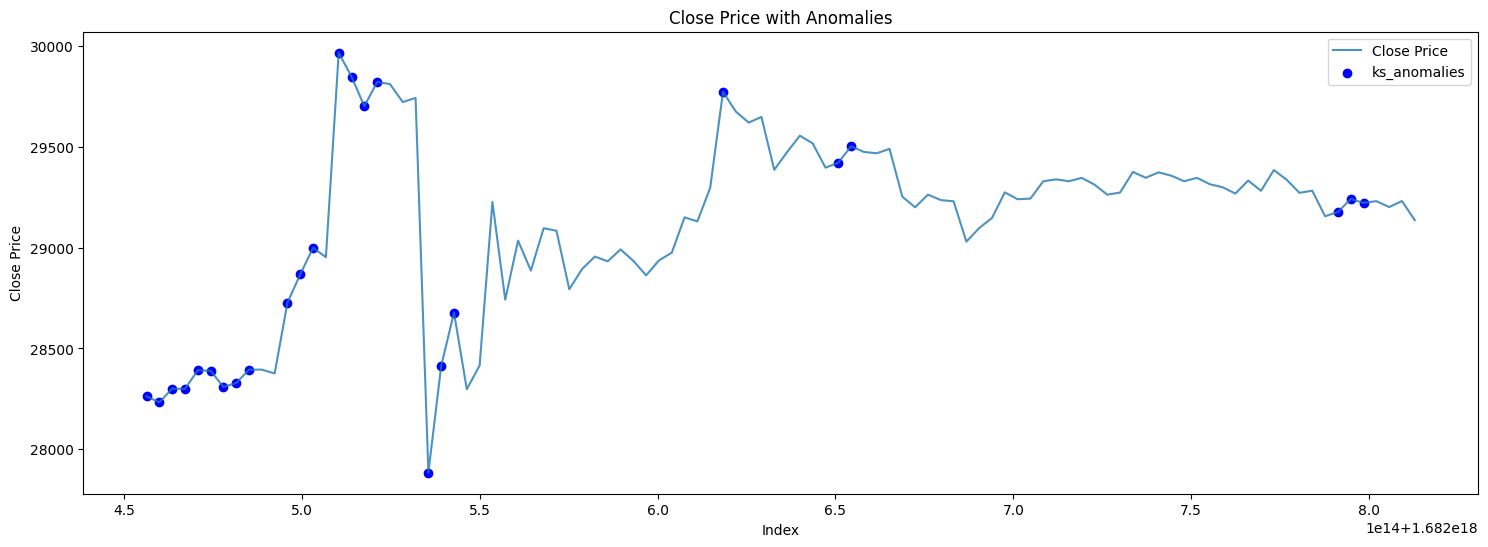

In [135]:
from scipy.stats import ks_2samp

def calculate_ks(window_data, overall_data):
    cdf_window = np.sort(window_data)
    cdf_overall = np.sort(overall_data)
    ks_statistic, _ = ks_2samp(cdf_window, cdf_overall)
    return ks_statistic

def calculate_ks_numpy(window_data, overall_data):
    cdf_window = np.sort(window_data)
    cdf_overall = np.sort(overall_data)
    
    n1 = len(cdf_window)
    n2 = len(cdf_overall)
    
    data_all = np.concatenate([cdf_window, cdf_overall])
    cdf_window = np.searchsorted(cdf_window, data_all, side='right') / n1
    cdf_overall = np.searchsorted(cdf_overall, data_all, side='right') / n2
    
    ks_statistic = np.max(np.abs(cdf_window - cdf_overall))
    return ks_statistic

def ks_anomalies(data, window_size, threshold):
    num_windows = len(data) - window_size + 1
    ks_values = np.zeros(num_windows)

    for i in range(num_windows):
        window_data = data[i:i + window_size]
        ks_values[i] = calculate_ks_numpy(window_data, data)

    anomalies = np.where(ks_values > threshold)[0]
    return anomalies

window_size = 5
threshold = 0.8

for column in columns_of_interest:
    data = df[column].values.astype(float)
    anomalies = ks_anomalies(data, window_size, threshold)
    df[f'{column}_ks_anomalies'] = 0
    df.iloc[anomalies, df.columns.get_loc(f'{column}_ks_anomalies')] = 1

df['ks_anomalies'] = np.where((df['open_ks_anomalies'] == 1) |
                              (df['high_ks_anomalies'] == 1) |
                              (df['low_ks_anomalies'] == 1) |
                              (df['close_ks_anomalies'] == 1) |
                              (df['returns_ks_anomalies'] == 1) |
                              (df['volume_ks_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'ks_anomalies')

## Iterated Cumulative Sums of Squares (ICSS) Test

The Iterated Cumulative Sums of Squares (ICSS) test is a statistical method used to detect multiple structural breaks or changes in variance in a time series. It was proposed by Inclan and Tiao (1994) as a way to identify volatility shifts in financial time series data.

The ICSS algorithm is based on the cumulative sums of squares (CSS) test, which is used to detect a single structural break. The ICSS test iteratively applies the CSS test to detect multiple breaks in the time series.

**Cumulative Sums of Squares (CSS) Test**

The CSS test is a statistical method for detecting a single structural break in the variance of a time series. The idea behind the test is to calculate the cumulative sum of the squared deviations from the mean for the entire time series and compare it with the cumulative sum of the squared deviations from the mean for each possible subseries.

Let $X_t$ be a zero-mean stationary time series, and let $n$ be the number of observations. The CSS statistic is given by:

$$CSS(t) = ∑_{i=1}^{t} (X_i^2 - X^2) - ∑_{i=t+1}^{n} (X_i^2 - X^2)$$

where $X_i^2$ is the squared observation at time $i$, and $X^2$ is the mean of the squared observations. The test statistic is the maximum of the absolute value of the CSS statistic:

$$S_n = max_{1 <= t <= n-1} |CSS(t)|$$

Under the null hypothesis of no structural break, the test statistic $S_n$ follows a Brownian bridge distribution. The critical values for the test statistic can be obtained through simulation.

**Iterated CSS (ICSS) Algorithm**

The ICSS algorithm extends the CSS test to detect multiple structural breaks in the variance of a time series. The main steps of the ICSS algorithm are:

Perform the CSS test on the entire time series to detect a single structural break.
If a structural break is detected, partition the time series into two subseries at the break point.
Repeat the CSS test on each subseries to detect additional structural breaks.
Continue this process iteratively until no more structural breaks are detected.


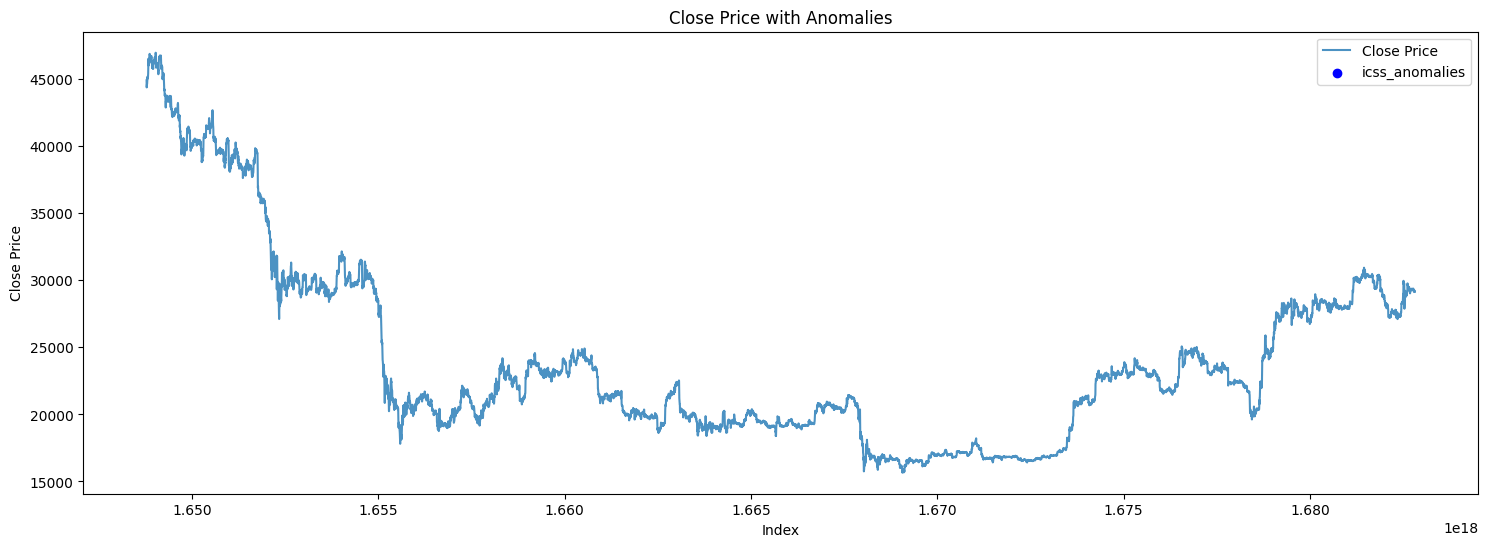

In [220]:
def css_test(x):
    n = len(x)
    if n <= 1:
        return 0, 0

    x_squared = x ** 2
    x_squared_mean = np.mean(x_squared)
    css_values = np.zeros(n - 1)

    for t in range(1, n):
        css_values[t - 1] = np.sum(x_squared[:t] - x_squared_mean) - np.sum(x_squared[t:] - x_squared_mean)

    test_statistic = np.max(css_values)
    break_point = np.argmax(css_values)
    return test_statistic, break_point

def icss(x, critical_value=1.358):
    breaks = []
    segments = [(0, len(x))]

    while len(segments) > 0:
        start, end = segments.pop(0)
        if end - start <= 1:
            continue
        test_statistic, break_point = css_test(x[start:end])

        if test_statistic > critical_value:
            break_point += start
            breaks.append(break_point)
            segments.append((start, break_point))
            segments.append((break_point, end))

    return sorted(breaks)

columns_of_interest = ['returns']

for column in columns_of_interest:
    data = df[column].values.astype(float)
    breaks = icss(data)
    df[f'{column}_icss_anomalies'] = 0
    for break_point in breaks:
        df.iloc[break_point, df.columns.get_loc(f'{column}_icss_anomalies')] = 1

df['icss_anomalies'] = np.where((df['returns_icss_anomalies'] == 1), 1, 0) 

plot_anomaly(df, 'icss_anomalies')

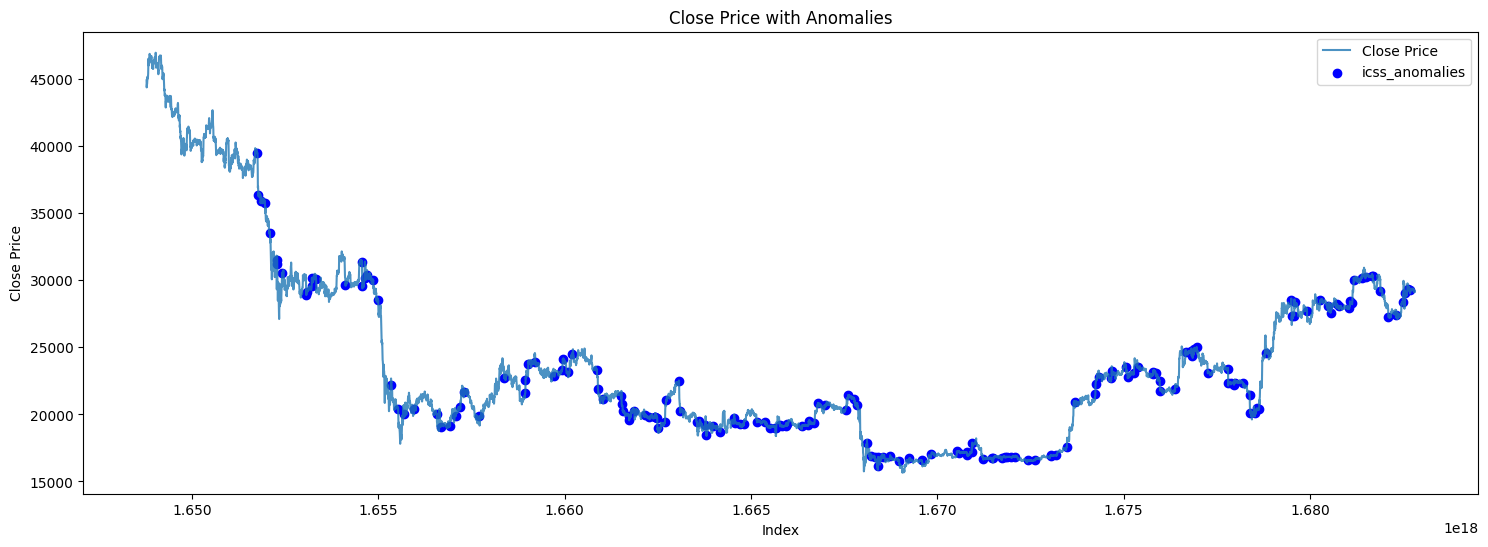

In [225]:
# Type 1 
def itt(data):
    T = len(data)
    squared = data ** 2
    Ck = np.cumsum(squared)
    CT = Ck[-1]
    ks = np.arange(1, T + 1)

    Dk = (Ck / CT) - (ks / T)
    Dk_plot = np.sqrt(T / 2) * Dk
    Dk_max = np.max(np.abs(Dk_plot))
    k_star = np.argmax(np.abs(Dk))

    return Dk_plot, Dk_max, k_star

def icss(data, demean=False, significance_level=1.358):
    if demean:
        data = data - np.mean(data)

    change_points = []

    def search(start, end):
        if end - start < 2:
            return

        _, test_value, position = itt(data[start:end])

        if test_value > significance_level:
            position += start
            change_points.append(position)
            search(start, position)
            search(position + 1, end)

    search(0, len(data))

    return sorted(change_points)


columns_of_interest = ['returns', 'volume', 'open', 'high', 'low', 'close']

df = df_.copy()

for column in columns_of_interest:
    data = df[column].values.astype(float)
    breaks = icss(data, significance_level=1.382)
    df[f'{column}_icss_anomalies'] = 0
    for break_point in breaks:
        df.iloc[break_point, df.columns.get_loc(f'{column}_icss_anomalies')] = 1

df['icss_anomalies'] = np.where((df['returns_icss_anomalies'] == 1), 1, 0) 

plot_anomaly(df, 'icss_anomalies')


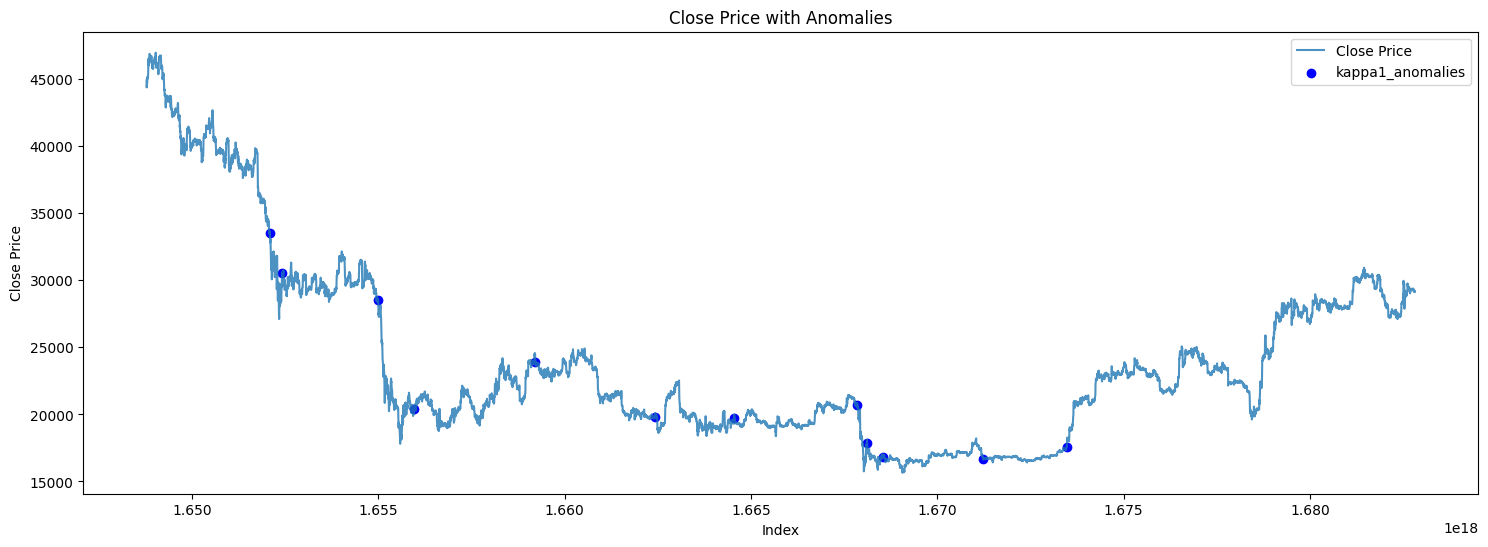

In [226]:
def kappa1(data):
    """
    Ref.fokep: Sansó et al. Testing for Changes in the Unconditional Variance of
    Financial Time Series, Chapter 2
    """
    Ck = np.cumsum(data ** 2)
    CT = Ck[-1]
    T = len(data)
    ks = np.arange(1, T + 1)

    a4 = np.cumsum(data ** 4)
    a4 = a4[-1] / T
    s2 = CT / T
    c = np.sqrt(a4 - (s2 ** 2))

    Bk = (Ck - ((ks / T) * CT)) / c
    Bk_plot = (1 / np.sqrt(T)) * Bk
    Bk_max = np.max(np.abs(Bk_plot))
    k_star = np.argmax(np.abs(Bk))

    return Bk_plot, Bk_max, k_star

def icss_kappa1(data, demean=False, significance_level=1.358):
    if demean:
        data = data - np.mean(data)

    change_points = []

    def search(start, end):
        if end - start < 2:
            return

        _, test_value, position = kappa1(data[start:end])

        if test_value > significance_level:
            position += start
            change_points.append(position)
            search(start, position)
            search(position + 1, end)

    search(0, len(data))

    return sorted(change_points)

columns_of_interest = ['returns', 'volume', 'open', 'high', 'low', 'close']

df = df_.copy()

for column in columns_of_interest:
    data = df[column].values.astype(float)
    breaks = icss_kappa1(data)
    df[f'{column}_kappa1_anomalies'] = 0
    for break_point in breaks:
        df.iloc[break_point, df.columns.get_loc(f'{column}_kappa1_anomalies')] = 1

df['kappa1_anomalies'] = np.where((df['returns_kappa1_anomalies'] == 1), 1, 0)

plot_anomaly(df, 'kappa1_anomalies')

## Bayesian Structural Time Series (BSTS)

Bayesian Structural Time Series (BSTS) is a powerful modeling framework for analyzing time series data. It is based on Bayesian inference, which allows for a more flexible and expressive approach to modeling time series compared to traditional methods like ARIMA or Exponential Smoothing. By incorporating prior knowledge and updating the model as new data becomes available, BSTS can produce better forecasts and gain insights into the underlying structure of the time series.

**Introduction to Bayesian Inference**

Bayesian inference is a statistical method that allows for the incorporation of prior knowledge into the analysis of data. It is based on Bayes' theorem, which relates the conditional probabilities of events. In the context of time series analysis, Bayesian inference can be used to update our beliefs about model parameters as new data becomes available.

Bayes' theorem states:

$$P(A|B) = (P(B|A) * P(A)) / P(B)$$

Where:

- $P(A|B)$ is the posterior probability of event $A$ given event $B$
- $P(B|A)$ is the likelihood of event $B$ given event $A$
- $P(A)$ is the prior probability of event $A$
- $P(B)$ is the probability of event $B$

In time series analysis, we are interested in estimating the posterior distribution of the model parameters given the observed data. By combining the likelihood of the data given the parameters with our prior beliefs about the parameters, we can arrive at an updated posterior distribution that reflects both the data and our prior knowledge.

**Structural Time Series Models**

Structural time series models are a class of models that decompose a time series into its underlying components, such as trend, seasonality, and irregular fluctuations. A basic structural time series model can be expressed as:

$$y_t = trend_t + seasonal_t + irregular_t$$

Where:

- $y_t$ is the observed value at time $t$
- $trend_t$ is the trend component at time $t$
- $seasonal_t$ is the seasonal component at time $t$
- $irregular_t$ is the irregular component at time $t$

These components can be further modeled using various techniques, such as autoregressive or moving average processes, allowing for a flexible and expressive representation of the time series.

**State Space Representation**

State space representation is a mathematical framework that allows for the compact representation of time series models, particularly structural time series models. A state space model is typically expressed in the form of two equations:

- The observation equation, which relates the observed data to the underlying state variables
- The state equation, which describes the evolution of the state variables over time

For a structural time series model, the state space representation can be written as:
$$y_t = Z_t * alpha_t + epsilon_t$$
$$alpha_t+1 = T_t * alpha_t + R_t * eta_t
$$

Where:

- $y_t$ is the observed value at time $t$
- $Z_t$ is the observation matrix at time $t$
- $alpha_t$ is the state vector at time $t$
- $epsilon_t$ is the observation error at time $t$
- $T_t$ is the state transition matrix at time $t$
- $R_t$ is the state error matrix at time $t$
- $eta_t$ is the state error at time $t$

**Kalman Filter and Smoothing**

The Kalman filter is a recursive algorithm for estimating the state variables in a state space model given the observed data. It consists of two steps:

- The prediction step, where the state variables are updated based on the state transition matrix and the current state estimates

- The update step, where the state estimates are refined based on the observation error and the likelihood of the observed data

The Kalman filter can be extended to perform smoothing, which involves estimating the state variables for all time points simultaneously. This can provide more accurate estimates of the state variables, as it takes into account the entire observed data rather than just the data up to a certain time point.

**Bayesian Forecasting and Model Selection**

In the context of BSTS, Bayesian forecasting involves generating predictions for future time points based on the estimated state variables and the posterior distribution of the model parameters. This can be accomplished using Monte Carlo simulations, where multiple draws from the posterior distribution are used to generate a distribution of forecasts for each future time point. The mean, median, or other quantiles of this distribution can then be used as point forecasts, and the spread of the distribution can be used to quantify the uncertainty in the forecasts.

Model selection in BSTS involves choosing the best model from a set of candidate models based on their ability to explain the observed data and make accurate forecasts. This can be accomplished using Bayesian model comparison techniques, such as the Bayes factor or the Deviance Information Criterion (DIC). These measures take into account both the goodness of fit of the model and the complexity of the model, favoring models that provide a good balance between the two.



In [ ]:
#fix later

"""
Install dependencies:
pip install numpy pandas matplotlib Cython cmdstanpy pystan LunarCalendar convertdate holidays setuptools-git python-dateutil tqdm

Install Prophet:
pip install git+https://github.com/facebook/prophet.git#subdirectory=python

Incase of M2 chip, fix tbb: Intel TBB library (Thread Building Blocks) using:
conda install -c conda-forge tbb

"""

import pandas as pd
import numpy as np
from prophet import Prophet


data = df_.reset_index()[['timestamp', 'close']]
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.columns = ['ds', 'y']


model = Prophet()
model.fit(data)


future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)
residuals = data['y'].values - forecast['yhat'].values
threshold = 3 * np.std(residuals)

data['prophet_anomalies'] = np.where(np.abs(residuals) > threshold, 1, 0)

# Plot anomalies
data = data.set_index('ds')
plot_anomaly(data.reset_index(), 'prophet_anomalies')


## Grubbs' Test

Grubbs' Test, also known as the Grubbs' outlier test, is a statistical procedure used to detect outliers in a univariate data set. It is based on the assumption that the data follows a normal distribution. Grubbs' Test is particularly useful when dealing with small sample sizes (less than 50 data points), as it is sensitive enough to identify a single outlier in the dataset.

Grubbs' Test works by comparing the most extreme data point (the largest or the smallest value) to the mean and standard deviation of the entire dataset. If the difference between the extreme value and the mean is significantly larger than the standard deviation, the data point is considered an outlier. The test calculates a test statistic called the Grubbs' statistic (G) and compares it to a critical value derived from the t-distribution. If the test statistic is larger than the critical value, the null hypothesis (that there are no outliers) is rejected, and the extreme value is considered an outlier.

Steps involved in performing Grubbs' Test:

- Calculate the mean and standard deviation of the dataset.
- Identify the most extreme data point (either the largest or the smallest value).
- Calculate the absolute difference between the extreme value and the mean.
- Compute the Grubbs' statistic (G) for both the largest and smallest values.
- Determine the critical value from the t-distribution.
- Compare the Grubbs' statistic to the critical value.


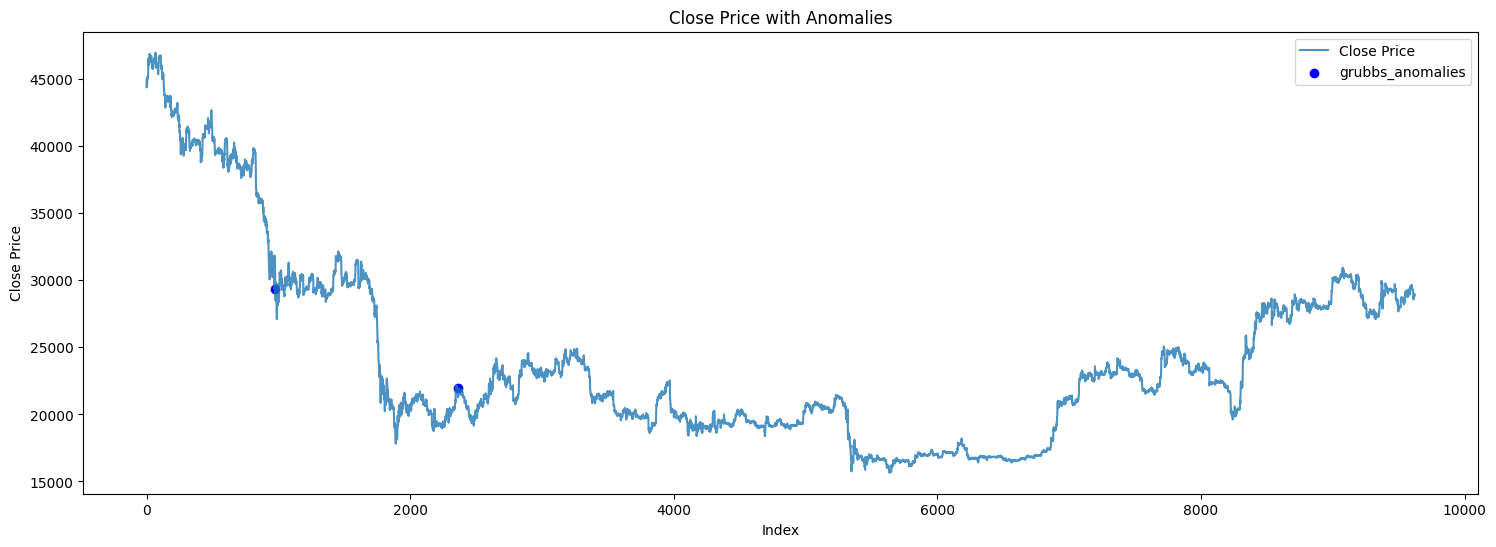

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def grubbs_test(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)

    t_critical = stats.t.ppf(1 - alpha / (2 * n), n - 2)
    critical_value = ((n - 1) * np.sqrt(np.square(t_critical))) / np.sqrt(n * (n - 2 + np.square(t_critical)))

    max_diff = np.abs(data - mean).max()
    max_index = np.argmax(np.abs(data - mean))

    grubbs_stat = max_diff / std_dev

    if grubbs_stat > critical_value:
        return max_index
    else:
        return -1

import numpy as np

def grubbs_test_np(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)

    t_critical = np.abs(np.percentile(np.random.standard_t(n - 2, size=10000), 100 * (1 - alpha / (2 * n))))
    critical_value = ((n - 1) * np.sqrt(np.square(t_critical))) / np.sqrt(n * (n - 2 + np.square(t_critical)))

    max_diff = np.abs(data - mean).max()
    max_index = np.argmax(np.abs(data - mean))

    grubbs_stat = max_diff / std_dev

    if grubbs_stat > critical_value:
        return max_index
    else:
        return -1


columns_of_interest = ['returns', 'volume', 'open', 'high', 'low', 'close'] #use of returns alone is better hence OR

df = df_.copy()

for column in columns_of_interest:
    data = df[column].values.astype(float)
    outlier_index = grubbs_test_np(data, alpha=.001)
    df[f'{column}_grubbs_anomalies'] = 0
    if outlier_index != -1:
        df.iloc[outlier_index, df.columns.get_loc(f'{column}_grubbs_anomalies')] = 1

df['grubbs_anomalies'] = np.where((df['returns_grubbs_anomalies'] == 1) | #OR
                                   (df['volume_grubbs_anomalies'] == 1) | 
                                   (df['open_grubbs_anomalies'] == 1) | 
                                   (df['high_grubbs_anomalies'] == 1) | 
                                   (df['low_grubbs_anomalies'] == 1) | 
                                   (df['close_grubbs_anomalies'] == 1), 1, 0)

plot_anomaly(df.reset_index(), 'grubbs_anomalies')


## One-Class Support Vector Machine (OCSVM)

One-Class Support Vector Machine (OCSVM) is an unsupervised machine learning algorithm for anomaly detection. It is a variant of the Support Vector Machine (SVM) that is specifically designed for single-class classification. The main idea behind OCSVM is to determine a decision boundary, or a hyperplane, that separates the data points in the feature space. This hyperplane is determined by maximizing the margin between the data points and the decision boundary, while considering a fraction of points that can be on the wrong side of the boundary as outliers.

The OCSVM algorithm is particularly suitable for detecting anomalies in high-dimensional datasets, where other statistical methods may struggle due to the curse of dimensionality.

**Algorithm description:**

Given a dataset X with n data points and d dimensions, OCSVM aims to find a decision boundary that maximizes the margin between the data points and the boundary. The decision boundary is defined by the following equation:

$$f(x) = w^T * x + b$$

Where $w$ is a weight vector, $x$ is a data point, $b$ is a bias term, and $^T$ denotes the transpose operation. The objective of OCSVM is to minimize the following cost function:

$$1/2 ||w||^2 + (1/nu) * sum(max(0, 1 - f(x_i)))$$

Here, $||w||^2$ is the squared norm of the weight vector, $nu$ is a hyperparameter controlling the trade-off between maximizing the margin and minimizing the number of outliers, and $max(0, 1 - f(x_i))$ is the hinge loss function. The cost function consists of two terms: the first term is a regularization term that aims to find a simpler model with smaller weights, and the second term is the loss term that penalizes the misclassified data points.

To solve the optimization problem, the dual problem is formulated using Lagrange multipliers $alpha_i$. The dual problem is then solved using quadratic programming techniques to find the optimal values of $alpha_i$. The final decision boundary is determined by the support vectors, which are the data points with non-zero $alpha_i$ values.


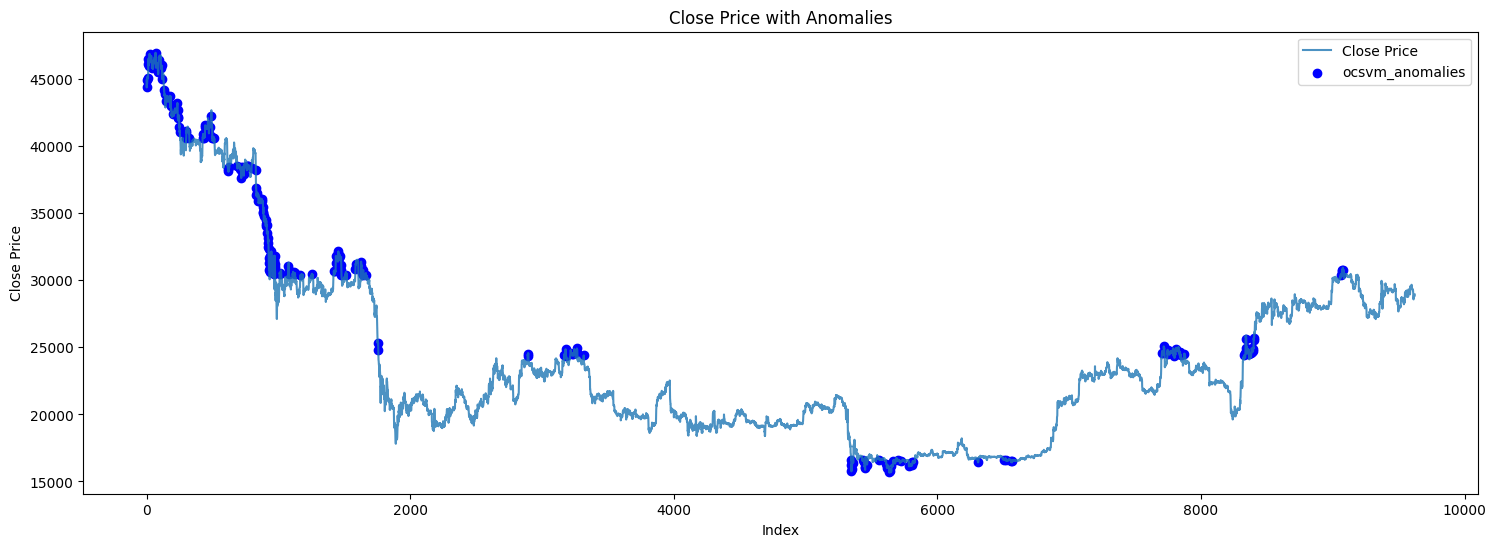

In [39]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

df = df_.copy()

def fit_ocsvm(data, nu=0.01, kernel='rbf', degree=3, gamma='scale', coef0=0.0):
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data.reshape(-1, 1))

    ocsvm = OneClassSVM(kernel=kernel, nu=nu, degree=degree, gamma=gamma, coef0=coef0)
    ocsvm.fit(data_standardized)
    return ocsvm, scaler

columns_of_interest = ['returns', 'volume', 'open', 'high', 'low', 'close']


for column in columns_of_interest:
    data = df[column].values.astype(float)
    ocsvm, scaler = fit_ocsvm(data, nu=0.151,degree=3, gamma='scale', coef0=0.0)#desired params

    data_standardized = scaler.transform(data.reshape(-1, 1))
    labels = ocsvm.predict(data_standardized)

    df[f'{column}_ocsvm_anomalies'] = np.where(labels == -1, 1, 0)

df['ocsvm_anomalies'] = np.where(
    (df['returns_ocsvm_anomalies'] == 1) &
    # (df['volume_ocsvm_anomalies'] == 1) &
    # (df['open_ocsvm_anomalies'] == 1) &
    # (df['high_ocsvm_anomalies'] == 1) &
    # (df['low_ocsvm_anomalies'] == 1) &
    (df['close_ocsvm_anomalies'] == 1), 1, 0)

plot_anomaly(df.reset_index(), 'ocsvm_anomalies')


# References:

- [Anomaly detection using exponential weighted moving average?](https://stats.stackexchange.com/questions/107472/anomaly-detection-using-exponential-weighted-moving-average)
- [Generalized Exponential Moving Average (EMA) Model with Particle Filtering and Anomaly Detection](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2833715)
- [Why “1.5” in IQR Method of Outlier Detection](https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097)
- [Mahalanobis Distance – Understanding the math with examples (python)](https://www.machinelearningplus.com/statistics/mahalanobis-distance/)
- [Outlier detection with Local Outlier Factor (LOF)](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html)
- [Sk-learn github-library](https://github.com/scikit-learn/scikit-learn/tree/364c77e047ca08a95862becf40a04fe9d4cd2c98/sklearn)
- [Unsupervised Outlier Detection with Isolation Forest](https://medium.com/mlearning-ai/unsupervised-outlier-detection-with-isolation-forest-eab398c593b2)
- [Earth mover’s distance](https://towardsdatascience.com/earth-movers-distance-68fff0363ef2)
- [Robust Statistical Distances for Machine Learning](https://www.datadoghq.com/blog/engineering/robust-statistical-distances-for-machine-learning/#:~:text=The%20Earth%20Mover's%20Distance%20is,between%20the%20two%20empirical%20CDFs.)
- [Iterative Cumulative Sum of Squares Algorithm](https://www.aptech.com/blog/a-simple-test-for-structural-breaks-in-variance/#:~:text=Iterative%20Cumulative%20Sum%20of%20Squares%20Algorithm,-Finding%20would%20be&text=The%20ICSS%20algorithm%20searches%20for,longer%20found%2C%20the%20search%20stops.)
- [ICSS in R](https://rdrr.io/cran/ICSS/src/R/ICSS.R)
- [Testing for Changes in the Unconditional Variance of Financial Time Series](https://www.researchgate.net/publication/24138907_Testing_for_Changes_in_the_Unconditional_Variance_of_Financial_Time_Series)
- [Grubbs’ Test for Outliers (Maximum Normed Residual Test)](https://www.statisticshowto.com/grubbs-test/)
- [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)